# OCR- number plate

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Extract Number Plate From Car

In [27]:
def extract_plate(img): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()

    #Loads the data required for detecting the license plates from cascade classifier.
    plate_cascade = cv2.CascadeClassifier('./indian_license_plate.xml')

    # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)

    for (x,y,w,h) in plate_rect:
        plate = plate_img[y:y+h, x:x+w]
        # finally representing the detected contours by drawing rectangles around the edges.
        cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)

    return plate_img, plate # returning the processed image.

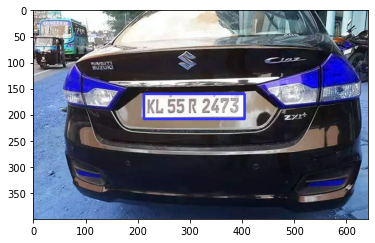

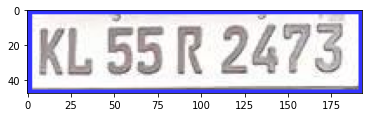

In [28]:
img = cv2.imread('images/002.jpg')
cool, hot = extract_plate(img)
plt.imshow(cool)
plt.show()
plt.imshow(hot)
plt.show()

# Find Contours and Segmentation of plate

In [7]:
def find_contours(dim, img):
    
    #find all countours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Retrieve potential dimensions
    lower_width = dim[0]
    upper_width = dim[1]
    lower_height = dim[2]
    upper_height = dim[3]
    
    # Check largest 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    
    for cntr in cntrs:
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth>lower_width and intWidth<upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX)
            # stores the x coordinate of the character's contour, to used later for indexing the contours
            
            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            
            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            
            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res 

In [8]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

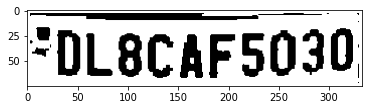

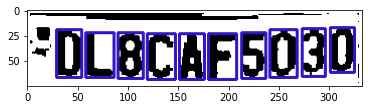

In [31]:
img = cv2.imread('images/car_plate.png')
char = segment_characters(img)

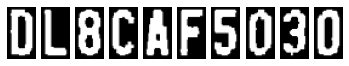

In [32]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

# Training Model For Characters

In [8]:
import tensorflow as tf

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)

train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [11]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

In [12]:
ACCURACY_THRESHOLD = 0.95

class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

In [13]:
import datetime
!rm -rf logs
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
batch_size = 1
model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 50, callbacks=tensorboard_callback)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
864/864 [==============================] - 21s 24ms/step - loss: 3.5229 - accuracy: 0.0613 - val_loss: 3.3585 - val_accuracy: 0.1945
Epoch 2/50
864/864 [==============================] - 21s 25ms/step - loss: 3.1486 - accuracy: 0.1956 - val_loss: 2.8124 - val_accuracy: 0.3820
Epoch 3/50
864/864 [==============================] - 21s 24ms/step - loss: 2.5296 - accuracy: 0.3623 - val_loss: 2.2347 - val_accuracy: 0.5546
Epoch 4/50
864/864 [==============================] - 22s 25ms/step - loss: 1.9969 - accuracy: 0.4618 - val_loss: 1.8204 - val_accuracy: 0.6073
Epoch 5/50
864/864 [==============================] - 21s 24ms/step - loss: 1.6176 - accuracy: 0.5891 - val_loss: 1.4618 - val_accuracy: 0.7110
Epoch 6/50
864/864 [==============================] - 22s 26ms/step - loss: 1.3963 - accuracy: 0.6227 - val_loss: 1.2508 - val_accuracy: 0.7415
Epoch 7/50
864/864 [==============================] - 21s 25

In [16]:
# !kill 8400
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [15]:
# save the model

model.save('model.h5') 

# Test the model

In [15]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list

    plate_number = ''.join(output)

    return plate_number

In [18]:
show_results()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


'0L8CAF5030'

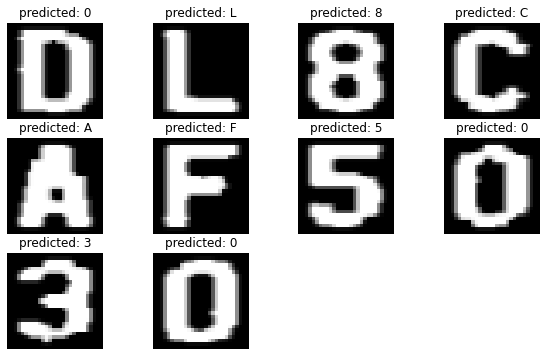

In [19]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [10]:
from detector.anpr import PyImageSearchANPR
import imutils
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
model = load_model('model.h5')

In [3]:
image = cv2.imread('./images/003.jpg')
image = imutils.resize(image, width=600)

In [4]:
anpr = PyImageSearchANPR()

(lpText, lpCnt) = anpr.find_and_ocr(image)

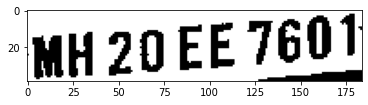

True

In [5]:
plt.imshow(lpText, cmap='gray')
plt.show()
cv2.imwrite('photo.png', lpText)

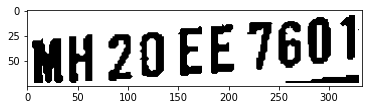

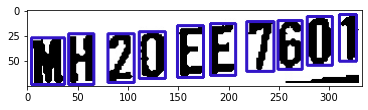

In [11]:
img = cv2.imread('photo.png')
char = segment_characters(img)

In [16]:
show_results(char)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


'4H20EE7601'